## Loading in the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 

# read in the electricity and weather data
df = pd.read_csv('data/CleanData.csv', index_col='DATE')
# dropping minutes
# df = df.drop(df.columns[5], axis=1)

# perform feature lagging
lag_hours = [1]
for lag_hour in lag_hours:
    df[f'Net kWh_lag_{lag_hour}'] = df['Net kWh'].shift(lag_hour)

lag_drybulbtemps = [1, 2, 3, 24]
for lag_drybulbtemp in lag_drybulbtemps:
    df[f'DryBulbTemp_lag_{lag_drybulbtemp}'] = df['HourlyDryBulbTemperature'].shift(lag_drybulbtemp)

lag_dewpoints = [1, 2, 3, 24]
for lag_dewpoint in lag_dewpoints:
    df[f'DewPointTemp_lag_{lag_dewpoint}'] = df['HourlyDewPointTemperature'].shift(lag_dewpoint)

#print(df.head())
# For now, I am dropping the rows with missing values.
print('Shape of data before dropping missing values:')
print(df.shape)
# by default, rows/points are dropped
df_r = df.dropna()
print('Shape of data after dropping missing values:')
print(df_r.shape)

Shape of data before dropping missing values:
(36807, 23)
Shape of data after dropping missing values:
(35668, 23)


## Setting up the ML Pipeline

In [2]:
# Creating the Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


# Arguments:
y = df_r['Net kWh']
X = df_r.loc[:, df.columns != 'Net kWh']


# One Hot Encoder for Categorical Features and Standard Scaler for Continuous Features
onehot_ftrs = ['calendar_year','month','open_to_students']
std_ftrs = ['week', 'hour', 'minute', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
            'HourlyRelativeHumidity', 'HourlyVisibility', 'HourlyWetBulbTemperature', 'HourlyWindDirection',
            'HourlyWindSpeed', 'DryBulbTemp_lag_1', 'DryBulbTemp_lag_2', 'DryBulbTemp_lag_3', 'DryBulbTemp_lag_24',
            'DewPointTemp_lag_1', 'DewPointTemp_lag_2', 'DewPointTemp_lag_3', 'DewPointTemp_lag_24', 'Net kWh_lag_1']

# Collect the two encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])

# Fit the Training Set and Transform the Training, Validation, and Test Sets
preprocess = Pipeline(steps=[('preprocessor', preprocessor)]) 

# function for the ML pipeline
def MLpipe_TimeSeriesSplit_RMSE(X, y, preprocessor, ML_algo, param_grid):

    # lists to be returned 
    test_scores = np.zeros(n_random_states)
    best_models = []

    final_models = []
    print(f'\n Model {ML_algo}: \n')
    
    for i in range(n_random_states):
        
        # Splitting the data
        X_other, X_test, y_other, y_test = train_test_split(X,y,test_size=0.1,shuffle=False)
        # splitter for other
        tss = TimeSeriesSplit(n_splits=5)
        
        # selecting the correct regression model
        if ML_algo==RandomForestRegressor:
            reg = ML_algo(random_state=18*i)
        elif ML_algo==SVR or ML_algo==KNeighborsRegressor:
            np.random.seed(21*i)
            reg = ML_algo()
        elif ML_algo==XGBRegressor:
            reg = ML_algo(random_state=21*i)
        else:
            reg = ML_algo()


            # if ML_algo==RandomForestRegressor or ML_algo==:
            # reg = ML_algo(random_state=18*i)
        
        # Preprocessing the data
        pipe = make_pipeline(preprocessor, reg)
        
        # Using GridSearchCV to test the various parameter combinations
        grid = GridSearchCV(pipe, param_grid=param_grid,
                            scoring='neg_mean_squared_error',
                            cv=tss, return_train_score=True, n_jobs=-1, verbose=True)
        
        # fit the model on other
        grid.fit(X_other, y_other)
        # save results into a data frame
        results = pd.DataFrame(grid.cv_results_)
        #print(results)
    
        print('best model parameters:', grid.best_params_)
        # save the model
        final_models.append(grid)
        # calculate and save the test score
        y_test_pred = final_models[-1].predict(X_test)
        test_scores[i] = (np.sqrt(mean_squared_error(y_test, y_test_pred)))
        print('test score:', test_scores[i])

        # Get the best model from the grid search
        best_model = grid.best_estimator_

        # Store the best model
        best_models.append(final_models[-1])
        # Access the fitted preprocessor from the best model
        fitted_preprocessor = best_model.named_steps['columntransformer']
        # Get the feature names after preprocessing
        feature_names = fitted_preprocessor.get_feature_names_out()

        # to access the training set later
        for i, (train_index, val_index) in enumerate(tss.split(X)):
            X_train_fold = X.iloc[train_index]
            y_train_fold = y.iloc[train_index]


    return test_scores, best_models, y_test_pred, y_test, X_test, feature_names, X_train_fold, fitted_preprocessor

## Cross Validation

In [3]:
import pickle
param_grid_linear = {
    
} 
param_grid_ridge = {
    'ridge__alpha': np.logspace(-7,3,11),
    'ridge__max_iter': [100000]
} 
# SVR
param_grid_svr = {
    'svr__gamma': np.logspace(-4, 5, 10),
    'svr__C': [1e-1, 1e0, 1e1]
} 
# KNeighbors Regressor
param_grid_kn = {
    'kneighborsregressor__n_neighbors': [1, 3, 10, 30],
    'kneighborsregressor__weights': ['uniform', 'distance']
} 

models = [LinearRegression, Ridge]
param_grids = [param_grid_linear, param_grid_ridge]
mean_test_scores = np.zeros(len(models))
sd_test_scores = np.zeros(len(models))

all_results = []

# Only 1 random state because all of these models and splitting strategies are deterministic
n_random_states = 1

for i, model in enumerate(models):
    param_grid = param_grids[i]
    
    # Run the ML pipeline and collect results
    test_scores, best_models, y_test_pred, y_test, X_test, feature_names, X_train_fold, fitted_preprocessor = MLpipe_TimeSeriesSplit_RMSE(
        X, y, preprocessor, ML_algo=model, param_grid=param_grid
    )

    for random_state in range(1, n_random_states + 1):
        # Print and save the results
        print(f'Test Mean (Random State {random_state}):', np.mean(test_scores))
        print(f'Test SD (Random State {random_state}):', np.std(test_scores))
        
        mean_test_scores[i] = np.mean(test_scores)
        sd_test_scores[i] = np.std(test_scores)
        
        # Save each model with the name of the model and random state
        model_name = f'{model.__name__}_{random_state}_grid'
        file_path = f'results/{model_name}.save'
        file = open(file_path, 'wb')
        pickle.dump((best_models[0].best_estimator_, X_test, y_test), file)
        file.close()
        
        # Save results to a list for later analysis
        all_results.append({
            'model_name': model_name,
            'mean_test_score': mean_test_scores[i],
            'sd_test_score': sd_test_scores[i],
            'best_params': best_models[0].best_params_
        })

# Save overall results
file = open('results/all_results.save', 'wb')
pickle.dump(all_results, file)
file.close()


 Model <class 'sklearn.linear_model._base.LinearRegression'>: 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
best model parameters: {}
test score: 14.52029837400121
Test Mean (Random State 1): 14.52029837400121
Test SD (Random State 1): 0.0

 Model <class 'sklearn.linear_model._ridge.Ridge'>: 

Fitting 5 folds for each of 11 candidates, totalling 55 fits
best model parameters: {'ridge__alpha': 100.0, 'ridge__max_iter': 100000}
test score: 14.568049690118773
Test Mean (Random State 1): 14.568049690118773
Test SD (Random State 1): 0.0


## Model Results

In [4]:
# Opening the saved models back up
model_names = ['LinearRegression', 'Ridge', 'SVR', 'KNeighborsRegressor']
# dictionaries to store models, X_test, and y_test
all_models = {}
all_X_test = {}
all_y_test = {}

for model_name in model_names:
    # Create the file path based on the naming format
    file_path = f'results/{model_name}_grid.save'
    
    # Open the file and load the model, X_test, and y_test
    file = open(file_path, 'rb')
    loaded_model, X_test, y_test = pickle.load(file)
    file.close()

    # Store the loaded model, X_test, and y_test in dictionaries
    all_models[model_name] = loaded_model
    all_X_test[model_name] = X_test
    all_y_test[model_name] = y_test

# Recalculating test_scores
test_scores = np.zeros(len(model_names))

for i, model_name in enumerate(model_names):
    # Calculate test scores for each model
    test_preds = all_models[model_name].predict(all_X_test[model_name])

    # Calculate mean and standard deviation for each model
    test_scores[i] = np.sqrt(mean_squared_error(all_y_test[model_name], test_preds))

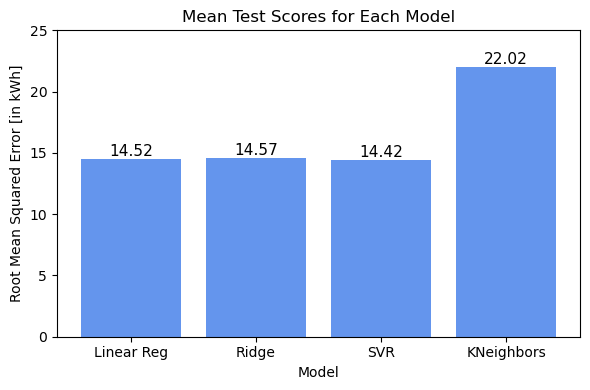

In [5]:
# Create bar chart for mean test scores with annotations
models = ['Linear Reg', 'Ridge', 'SVR', 'KNeighbors']
plt.figure(figsize=(6, 4))

bars = plt.bar(models, test_scores, color='cornflowerblue')
plt.xlabel('Model')
plt.ylabel('Root Mean Squared Error [in kWh]')
plt.ylim(0, 25)
plt.title('Mean Test Scores for Each Model')

# Add text annotations for each bar
for bar, score in zip(bars, test_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.2f}', 
             ha='center', va='bottom', color='black', fontsize=11)

plt.tight_layout()
# Save the plot as an image 
plt.savefig('images/Mean Test Scores for Each Model.png', dpi=300, bbox_inches='tight')
plt.show()


## Actual vs Predicted Values (kWh)

In [6]:
# creating a df of the test set to check the hourly baseline RMSE
df_y_test = pd.DataFrame(y_test)
df_X_test = pd.DataFrame(X_test)

master_dfs = [df_X_test['hour'], df_y_test]
final_df = pd.concat(master_dfs, axis=1)
final_df

# Calculating the RMSE baseline
y_baseline = y_test.mean()
y_baseline_preds = np.full_like(y_test, y_baseline)
print('Baseline RMSE:', np.sqrt(mean_squared_error(y_test, y_baseline_preds)))

# Group by hour and calculate the mean for each hour
hourly_means = final_df.groupby('hour')['Net kWh'].mean()

# Create an array of baseline predictions using the hourly means
y_baseline_preds_hourly = final_df['hour'].map(hourly_means)

# Calculate and print the RMSE
print('Hourly Baseline RMSE:', np.sqrt(mean_squared_error(final_df['Net kWh'], y_baseline_preds_hourly)))

# setting up dataframe to graph the test predictions
df_preds = pd.DataFrame({'actual': y_test, 'predicted': y_test_pred, 'baseline': y_baseline_preds})
#print(y_test)
df_preds.index = y_test.index
df_preds.head()

Baseline RMSE: 51.9408374242393
Hourly Baseline RMSE: 50.76022378257791


,actual,predicted,baseline
DATE,,,
2023-04-23 02:00:00,168.25,166.088584,169.94255
2023-04-23 03:00:00,134.00,162.468171,169.94255
2023-04-23 04:00:00,129.25,132.729208,169.94255
2023-04-23 05:00:00,126.75,129.646231,169.94255
2023-04-23 06:00:00,129.00,127.832018,169.94255


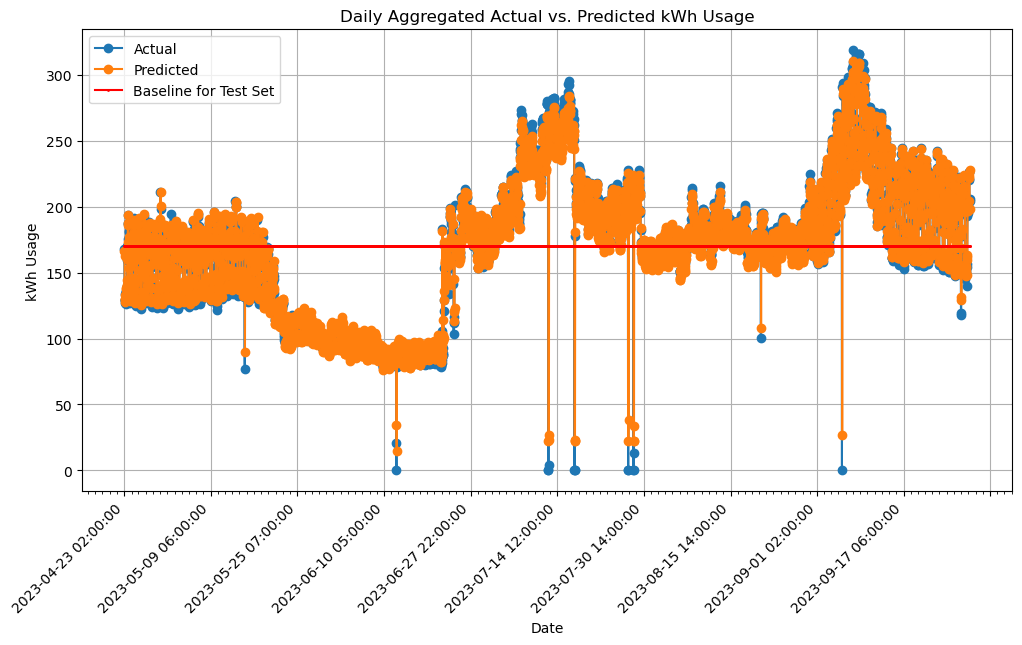

In [7]:
import matplotlib.pyplot as plt
import matplotlib 
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))
plt.plot(df_preds.index, df_preds['actual'], label='Actual', marker='o')
plt.plot(df_preds.index, df_preds['predicted'], label='Predicted', marker='o')
plt.plot(df_preds.index, df_preds['baseline'], label='Baseline for Test Set', marker='o', c='r', markersize=1)
plt.title('Daily Aggregated Actual vs. Predicted kWh Usage')
plt.xlabel('Date')
plt.ylabel('kWh Usage')
plt.legend()
plt.grid(True)

# Customizing x-axis ticks
plt.xticks(rotation=45, ha='right') 
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_minor_locator(plt.matplotlib.dates.MonthLocator())

# Save the plot as an image 
plt.savefig('images/ActualvsPredictedkWh1hourlag.png', dpi=300, bbox_inches='tight')
plt.show()

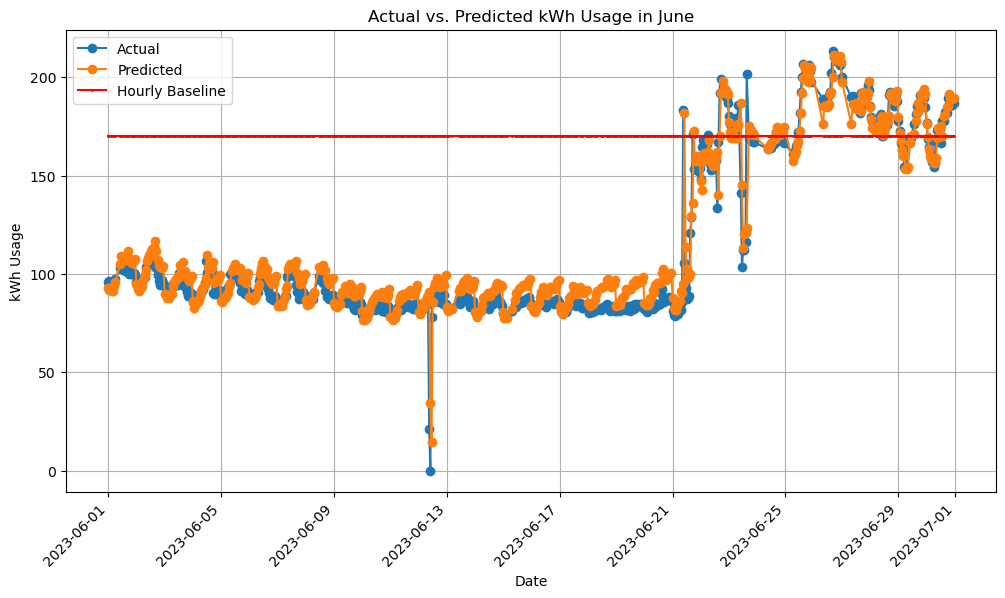

In [8]:
# Convert index to Timestamp if not already
df_preds.index = pd.to_datetime(df_preds.index)

# Filter data for the month of August
df_august = df_preds[df_preds.index.month == 6]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_august.index, df_august['actual'], label='Actual', marker='o')
plt.plot(df_august.index, df_august['predicted'], label='Predicted', marker='o')
plt.plot(df_august.index, df_august['baseline'], label='Hourly Baseline', marker='o', c='r', markersize=1)
plt.title('Actual vs. Predicted kWh Usage in June')
plt.xlabel('Date')
plt.ylabel('kWh Usage')
plt.legend()
plt.grid(True)

# Customizing x-axis ticks (optional)
plt.xticks(rotation=45, ha='right')
# Save the plot as an image 
plt.savefig('images/ActualvsPredictedkWhJune1hourlag.png', dpi=300, bbox_inches='tight')
plt.show()

## Global Feature Importance

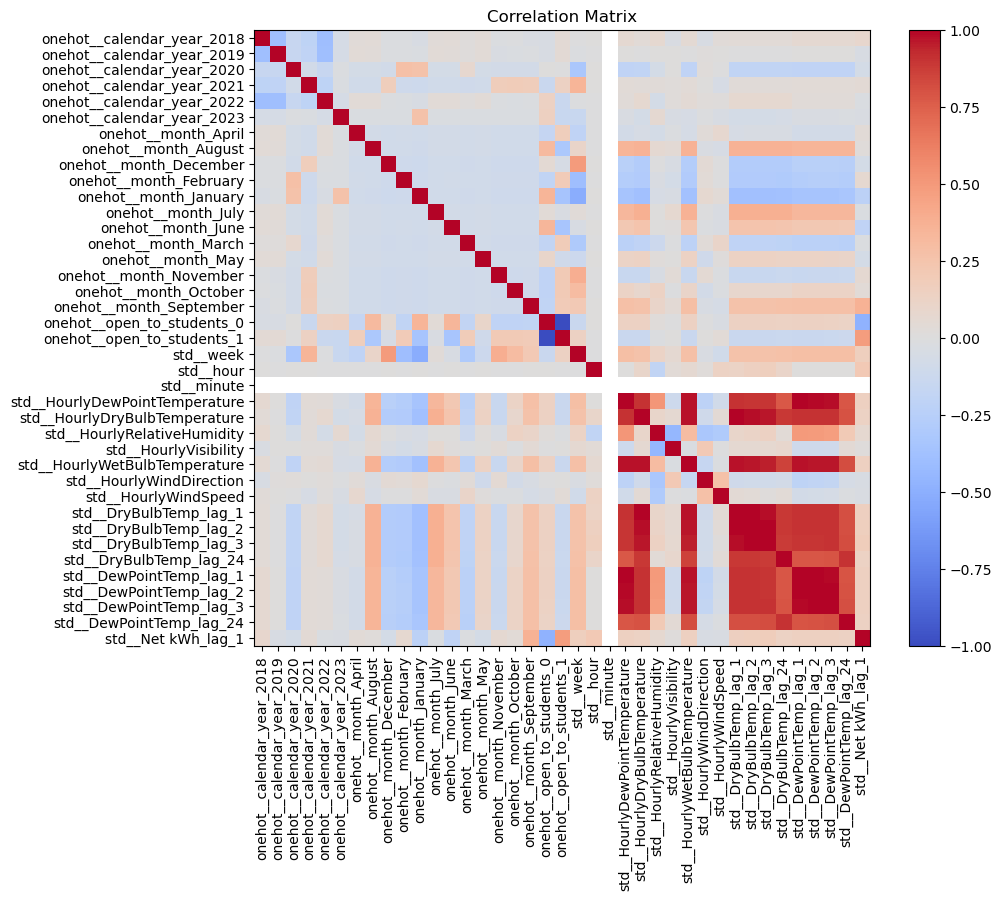

In [9]:
# Apply the preprocessing to the training sets
X_train_fold_preprocessed = preprocessor.fit_transform(X_train_fold)
feature_names = preprocessor.get_feature_names_out()

df_corr = pd.DataFrame(X_train_fold_preprocessed)
correlation_matrix = df_corr.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Correlation Matrix')

# Set custom labels for both axes
plt.xticks(range(len(feature_names)), feature_names, rotation=90)
plt.yticks(range(len(feature_names)), feature_names)

# Save the image
#plt.savefig('images/FeatureCorrelationMatrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# # SVR Shap
# import shap
# shap.initjs()

# # Load the saved grid from the pickle file
# with open('results/SVR_grid.save', 'rb') as file:
#     loaded_object = pickle.load(file)

# # Access the SVR model from the loaded object
# svr_model = loaded_object[0]['svr']

# # Transform the test set
# X_test_transformed = fitted_preprocessor.transform(X_test)

# # Wrap the model inside the KernelExplainer
# explainer = shap.KernelExplainer(model=svr_model.predict, data=X_test_transformed[200:220])

# # calculate shap values on the first 100 points in the test
# shap_values = explainer.shap_values(X_test_transformed[200:220])

# # shap summary plot
# shap.summary_plot(shap_values, X_test_transformed[200:220], feature_names=feature_names, show=False, max_display=10)

# plt.savefig('images/svr_20_shap_plot.png', dpi=300)

  0%|          | 0/20 [00:00<?, ?it/s]

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


  0%|          | 0/10 [00:00<?, ?it/s]

(3567, 39)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


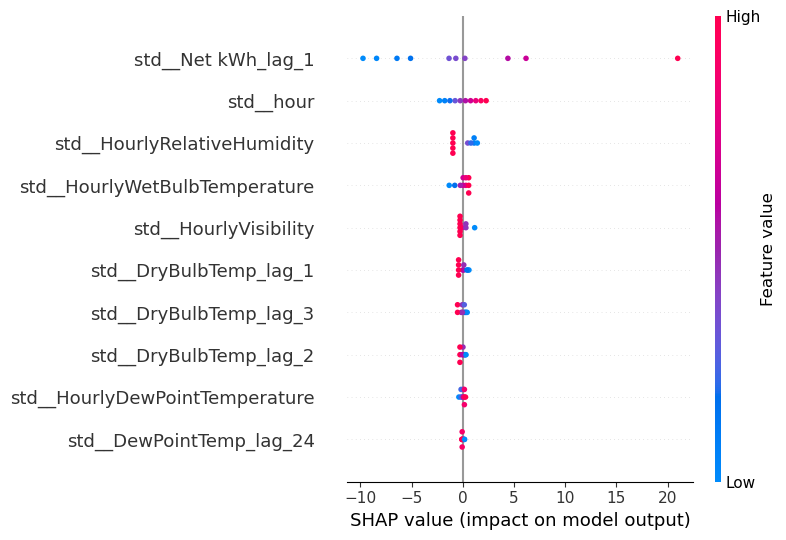

In [10]:
# Ridge Shap
import shap
shap.initjs()

# Load the saved grid from the pickle file
with open('results/Ridge_grid.save', 'rb') as file:
    loaded_object = pickle.load(file)

# Access the ridge model from the loaded object
ridge_model = loaded_object[0]['ridge']

# Transform the test set
X_test_transformed = fitted_preprocessor.transform(X_test)

# Wrap the model inside the KernelExplainer
explainer = shap.KernelExplainer(model=ridge_model.predict, data=X_test_transformed[200:210])

# calculate shap values on the first 100 points in the test
shap_values = explainer.shap_values(X_test_transformed[200:210])

# shap summary plot
shap.summary_plot(shap_values, X_test_transformed[200:210], feature_names=feature_names, show=False, max_display=10)

# plt.savefig('images/ridge_100_shap_plot.png', dpi=300)

print(X_test_transformed.shape)


## Local Feature Importance

In [11]:
index = 0
print('data point:', index,'; ' 'expected value', explainer.expected_value)
shap.force_plot(explainer.expected_value, shap_values[index,:], \
                features = X_test_transformed[index,:],feature_names = feature_names)

data point: 0 ; expected value 137.730704682904


In [13]:
index = 9
print('data point:', index,'; ' 'expected value', explainer.expected_value)
shap.force_plot(explainer.expected_value, shap_values[index,:], \
                features = X_test_transformed[index,:],feature_names = feature_names,show=False)

data point: 9 ; expected value 137.730704682904


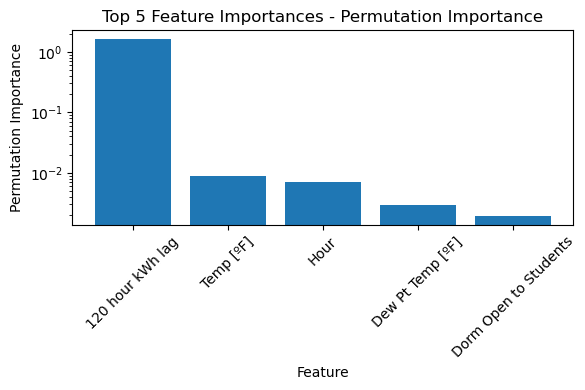

In [14]:
from sklearn.inspection import permutation_importance

# Transform the test set
X_test_transformed = fitted_preprocessor.transform(X_test)

# Assuming best_model is your trained model and X_test is your feature matrix
result = permutation_importance(ridge_model, X=X_test_transformed, y=y_test, n_repeats=10, random_state=0)

# Access the permutation importances, and feature names
importances = result.importances_mean
feature_names = feature_names

# Sort features based on importances
sorted_idx = importances.argsort()[::-1]
top_feature_names = feature_names[sorted_idx][:5]
top_importances = importances[sorted_idx][:5]

# Plot the top 5 feature importances
plt.figure(figsize=(6, 4))
plt.bar(range(len(top_importances)), top_importances, align="center")
names_for_chart = ['120 hour kWh lag', 'Temp [ºF]', 'Hour', 'Dew Pt Temp [ºF]', 'Dorm Open to Students']
plt.xticks(range(len(top_importances)), names_for_chart, rotation=45)
plt.xlabel("Feature")
plt.ylabel("Permutation Importance")
plt.yscale("log")
plt.title("Top 5 Feature Importances - Permutation Importance")
plt.tight_layout()
plt.savefig('images/permutation_importance_top5at120hours.png', dpi=300)
plt.show()


## Extra Analysis Showing Changes in Target Variable Feature Lag on Ridge Model

In [15]:
lag_hours = [1, 2, 24, 48, 72, 96, 120, 144, 168, 192, 216, 240, 264, 288, 312, 336, 360, 384, 408, 432, 456, 480]
models = [LinearRegression]
param_grids = [param_grid_linear]  # Assuming you have defined param_grid_ridge somewhere

onehot_ftrs = ['calendar_year', 'month', 'open_to_students']
std_ftrs = ['week', 'hour', 'minute', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
            'HourlyRelativeHumidity', 'HourlyVisibility', 'HourlyWetBulbTemperature', 'HourlyWindDirection',
            'HourlyWindSpeed']

# Lists to store results
lag_hours_list = []
test_mean_list = []
test_sd_list = []

for lag_hour in lag_hours:
    # Create a copy of the original dataframe
    df_copy = df.copy()
    print(df_copy.shape)

    # Perform feature lagging for the current lag_hour
    df_copy[f'Net kWh_lag_{lag_hour}'] = df_copy['Net kWh'].shift(lag_hour)
    df_copy = df_copy.dropna()
    #print(df_copy.head())

    # Arguments:
    y = df_copy['Net kWh']
    X = df_copy.loc[:, df_copy.columns != 'Net kWh']

    # Collect the two encoders
    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), onehot_ftrs),
            ('std', StandardScaler(), std_ftrs),
            ('lag', StandardScaler(), [f'Net kWh_lag_{lag_hour}'])])

    # Fit the Training Set and Transform the Training, Validation, and Test Sets
    preprocess = Pipeline(steps=[('preprocessor', preprocessor)])

    for i, model in enumerate(models):
        param_grid = param_grids[i]

        # Call your ML pipeline function for training and evaluation
        test_scores, best_models, y_test_pred, y_test, X_test, feature_names, X_train_fold, fitted_preprocessor = MLpipe_TimeSeriesSplit_RMSE(
            X, y, preprocessor, ML_algo=LinearRegression, param_grid=param_grid_linear)

        # Store the results in the lists
        lag_hours_list.append(lag_hour)
        test_mean_list.append(np.mean(test_scores))
        test_sd_list.append(np.std(test_scores))

        # Print or store the results
        print(f'Model: {model.__name__}, Lag Hour: {lag_hour}')
        print('Test Mean:', np.mean(test_scores))
        print('Test SD:', np.std(test_scores))

(36807, 23)

 Model <class 'sklearn.linear_model._base.LinearRegression'>: 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
best model parameters: {}
test score: 14.567419318736793
Model: LinearRegression, Lag Hour: 1
Test Mean: 14.567419318736793
Test SD: 0.0
(36807, 23)

 Model <class 'sklearn.linear_model._base.LinearRegression'>: 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
best model parameters: {}
test score: 19.918082820450216
Model: LinearRegression, Lag Hour: 2
Test Mean: 19.918082820450216
Test SD: 0.0
(36807, 23)

 Model <class 'sklearn.linear_model._base.LinearRegression'>: 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
best model parameters: {}
test score: 22.55114394836058
Model: LinearRegression, Lag Hour: 24
Test Mean: 22.55114394836058
Test SD: 0.0
(36807, 23)

 Model <class 'sklearn.linear_model._base.LinearRegression'>: 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
best model parameters: {}
test score: 26.37325

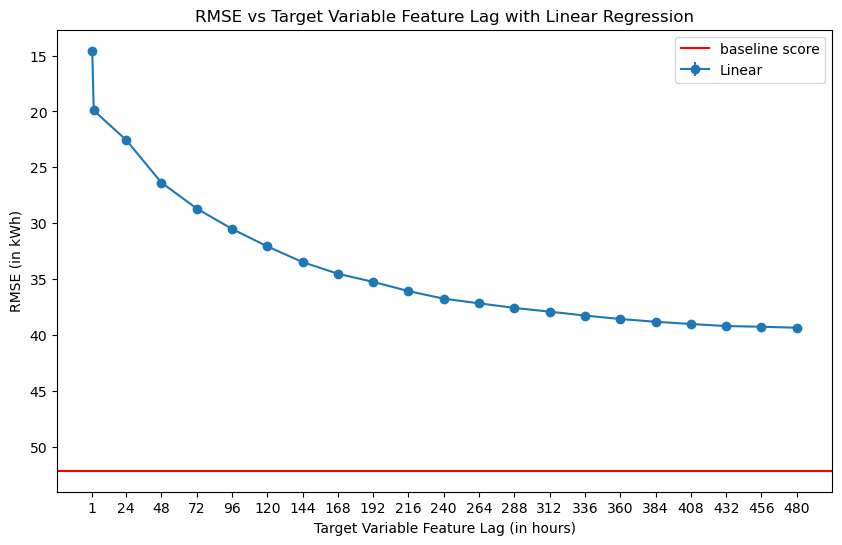

In [16]:
# Calculating the RMSE baseline
y_baseline = y_test.mean()
y_baseline_preds = np.full_like(y_test, y_baseline)
baseline_score = np.sqrt(mean_squared_error(y_test, y_baseline_preds))


# Plotting the RMSE against lag hours
plt.figure(figsize=(10, 6))
plt.errorbar(lag_hours_list, test_mean_list, yerr=test_sd_list, label='Linear', marker='o')
plt.axhline(baseline_score,label='baseline score', c='r')
plt.title('RMSE vs Target Variable Feature Lag with Linear Regression')
plt.xlabel('Target Variable Feature Lag (in hours)')

# Set custom tick positions and labels for x-axis
custom_ticks = lag_hours.copy()
custom_ticks.remove(2)  
plt.xticks(custom_ticks)
                   
plt.ylabel('RMSE (in kWh)')
plt.gca().invert_yaxis()
plt.legend()
plt.savefig('images/rmse_vs_target.png', dpi=300)
plt.show()